<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>HSC Cosmos Analysis Notebook</b> <br>
Contact author: Erin Howard<br>
Last verified to run: December 5, 2022<br>
LSST Science Piplines version: w_2022_46<br>
Container Size: Large <br>

modified by Eric Bellm as part of testing for DIAObject sprint in Dec 2022

# DIAObject sprint, December 2022: Selecting "good" variables

after notebook from DM-35285: ApPipeWithFakes on HSC COSMOS, November 2022

New baseline run, still using "new diffim" (before the big refactor).

* Used weekly `w_2022_46` with default convolution mode
* Working directory on USDF with bps logs, pipelines, etc. is `/sdf/group/rubin/user/elhoward/repo-main-logs/DM-35285`
* Templates are in `u/mrawls/DM-34711/templates`
* Final processing of HSC COSMOS is in `u/elhoward/DM-35285/hsc-output-collection`
* Postgres schema is `elhoward_dm35285_hsc_appipewithfakes`

For ApPipeWithFakes.yaml:
```
inCollection: u/mrawls/DM-34711/templates,HSC/raw/RC2/9813,HSC/calib,HSC/masks,refcats,skymaps
dataQuery: "instrument='HSC' AND skymap='hsc_rings_v1' AND band IN ('g', 'r', 'i', 'z', 'y')"
```

In [2]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd
import astropy.units as u
import lsst.afw.display as afwDisplay
import lsst.geom

import lsst.daf.butler as dafButler

from lsst.analysis.ap import apdb

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from IPython.display import Image, display

## 1. Loading DiaObjects and DiaSources

In [3]:
repo = '/repo/main'
butler = dafButler.Butler(repo)
instrument = 'HSC'
skymap = 'hsc_rings_v1'

dbType='postgres'
dbName='lsst-devl'

collections = 'u/elhoward/DM-35285/hsc-output-collection'
schema = 'elhoward_dm35285_hsc_appipewithfakes'
month = 'November'
year = '2022'

collections_old = 'u/smart/DM-36389/hsc-output-collection'
schema_old = 'smart_dm36389_hsc_fakes_rerun'
month_old = 'October'
year_old = '2022'

collectionsList = [collections,collections_old]

In [4]:

butler = lsst.daf.butler.Butler(repo, collections=collections)
apdbQuery = apdb.ApdbPostgresQuery(schema, butler=butler, instrument=instrument)


In [ ]:
#sources = apdbQuery.load_sources()
#objects = apdbQuery.load_objects()
#one_object = apdbQuery.load_sources_for_object(SOME_OBJECT_ID)

## test writing raw SQL queries to the APDB

the legacy utils only give us a few columns.  Raw sql time

In [5]:
with apdbQuery.connection as connection:
     testTable = pd.read_sql_query('select "diaObjectId", "ra", "decl", "nDiaSources", \
                                    "gPSFluxMean", "rPSFluxMean", "iPSFluxMean", \
                                    "zPSFluxMean", "yPSFluxMean", "validityEnd", "flags" from {0} \
                                    where "validityEnd" is NULL LIMIT 100;'.format('"DiaObject"'), connection)

In [6]:
testTable

,diaObjectId,ra,decl,nDiaSources,gPSFluxMean,rPSFluxMean,iPSFluxMean,zPSFluxMean,yPSFluxMean,validityEnd,flags
0,9717926147916312,150.874729,2.350798,1,None,NaN,NaN,NaN,1232.587926,None,1
1,9732546216591920,150.873182,2.356089,2,None,NaN,NaN,NaN,4448.875247,None,1
2,13092018095915533,150.871356,2.379869,2,None,NaN,-475.086307,NaN,1309.996970,None,1
3,5039847769113514,150.870091,2.387772,2,None,NaN,NaN,NaN,3266.279123,None,1
4,521529288820947,150.535431,2.287965,2,None,-35.908517,NaN,NaN,NaN,None,1
...,...,...,...,...,...,...,...,...,...,...,...
95,13096334538049410,150.473572,2.285980,1,None,NaN,288.237223,NaN,NaN,None,1
96,9720528898097643,150.080724,2.534144,1,None,NaN,NaN,NaN,1090.874994,None,1
97,9717926147916382,150.865334,2.394468,1,None,NaN,NaN,NaN,1315.665263,None,1
98,9717926147916383,150.865115,2.396599,1,None,NaN,NaN,NaN,1363.965705,None,1


In [7]:
testTable.loc[testTable['gPSFluxMean'].isna(),'gPSFluxMean']

0     None
1     None
2     None
3     None
4     None
      ... 
95    None
96    None
97    None
98    None
99    None
Name: gPSFluxMean, Length: 100, dtype: object

In [8]:
with apdbQuery.connection as connection:
    print(pd.read_sql_query('select count("diaObjectId") from "DiaObject" where "validityEnd" is NULL', connection))

     count
0  2450334


In [9]:
with apdbQuery.connection as connection:
    print(pd.read_sql_query('select count("diaSourceId") from "DiaSource"', connection))

     count
0  5007735


In [10]:
with apdbQuery.connection as connection:
    print(pd.read_sql_query('select * from "DiaSource" LIMIT 1', connection).columns.to_list())

['diaSourceId', 'ccdVisitId', 'diaObjectId', 'ssObjectId', 'parentDiaSourceId', 'prv_procOrder', 'ssObjectReassocTime', 'midPointTai', 'ra', 'raErr', 'decl', 'declErr', 'ra_decl_Cov', 'x', 'xErr', 'y', 'yErr', 'x_y_Cov', 'apFlux', 'apFluxErr', 'snr', 'psFlux', 'psFluxErr', 'psRa', 'psRaErr', 'psDecl', 'psDeclErr', 'psFlux_psRa_Cov', 'psFlux_psDecl_Cov', 'psRa_psDecl_Cov', 'psLnL', 'psChi2', 'psNdata', 'trailFlux', 'trailFluxErr', 'trailRa', 'trailRaErr', 'trailDecl', 'trailDeclErr', 'trailLength', 'trailLengthErr', 'trailAngle', 'trailAngleErr', 'trailFlux_trailRa_Cov', 'trailFlux_trailDecl_Cov', 'trailFlux_trailLength_Cov', 'trailFlux_trailAngle_Cov', 'trailRa_trailDecl_Cov', 'trailRa_trailLength_Cov', 'trailRa_trailAngle_Cov', 'trailDecl_trailLength_Cov', 'trailDecl_trailAngle_Cov', 'trailLength_trailAngle_Cov', 'trailLnL', 'trailChi2', 'trailNdata', 'dipMeanFlux', 'dipMeanFluxErr', 'dipFluxDiff', 'dipFluxDiffErr', 'dipRa', 'dipRaErr', 'dipDecl', 'dipDeclErr', 'dipLength', 'dipLength

this appears to be all of the columns in [sdm_schemas.apdb.yaml](https://github.com/lsst/sdm_schemas/blob/main/yml/apdb.yaml) even though they are not all populated at present by [ap_association](https://github.com/lsst/ap_association/blob/main/data/DiaSource.yaml)

In [11]:
with apdbQuery.connection as connection:
    print(pd.read_sql_query('select * from "DiaObject" LIMIT 1', connection).columns.to_list())

['diaObjectId', 'validityStart', 'validityEnd', 'ra', 'raErr', 'decl', 'declErr', 'ra_decl_Cov', 'radecTai', 'pmRa', 'pmRaErr', 'pmDecl', 'pmDeclErr', 'parallax', 'parallaxErr', 'pmRa_pmDecl_Cov', 'pmRa_parallax_Cov', 'pmDecl_parallax_Cov', 'pmParallaxLnL', 'pmParallaxChi2', 'pmParallaxNdata', 'uPSFluxMean', 'uPSFluxMeanErr', 'uPSFluxSigma', 'uPSFluxChi2', 'uPSFluxNdata', 'uFPFluxMean', 'uFPFluxMeanErr', 'uFPFluxSigma', 'gPSFluxMean', 'gPSFluxMeanErr', 'gPSFluxSigma', 'gPSFluxChi2', 'gPSFluxNdata', 'gFPFluxMean', 'gFPFluxMeanErr', 'gFPFluxSigma', 'rPSFluxMean', 'rPSFluxMeanErr', 'rPSFluxSigma', 'rPSFluxChi2', 'rPSFluxNdata', 'rFPFluxMean', 'rFPFluxMeanErr', 'rFPFluxSigma', 'iPSFluxMean', 'iPSFluxMeanErr', 'iPSFluxSigma', 'iPSFluxChi2', 'iPSFluxNdata', 'iFPFluxMean', 'iFPFluxMeanErr', 'iFPFluxSigma', 'zPSFluxMean', 'zPSFluxMeanErr', 'zPSFluxSigma', 'zPSFluxChi2', 'zPSFluxNdata', 'zFPFluxMean', 'zFPFluxMeanErr', 'zFPFluxSigma', 'yPSFluxMean', 'yPSFluxMeanErr', 'yPSFluxSigma', 'yPSFluxChi

## Try to select Variable Sources

We want to make this selection without having to load all of the DIASource lightcurves.  So we need to make use of the DIAObject summary statistics.  

One question is what flag propagation we have up from the individual DIASources.  Per [this link](https://github.com/lsst/meas_base/blob/26961ef6c7a3bd91c4b40a0307c740244fea775e/python/lsst/meas/base/diaCalculationPlugins.py#L228) it looks like we do have flagging propagated up (if any flag is set it sets the DIAObject flag?)

How do we define a variable source?  

* has a template counterpart ⇒ totflux > 0 catches both galaxies and variable stars. 

Would be good to have a PSF measure, but the eventual DRP crossmatch will handle this

* can also select for amplitudes (both positive and negative DIA flux amplitudes is too conservative but would find variables)

How do we make sure they are good?

* individual DIASource chisqr, RB score, flags, etc...  expensive to look up one by one

In [12]:
bands = ['u','g','r','i','z','y']
base_cols = ['PSFluxNdata']

cols_to_return = []

for col in base_cols:
    for band in bands:
        cols_to_return.append(f'max("{band}{col}")')

#query = f'select "diaObjectId", {", ".join(cols_to_return)} from "DiaObject" LIMIT 10'
query = f'select {", ".join(cols_to_return)} from "DiaObject" LIMIT 10'

print(query)

with apdbQuery.connection as connection:
    print(pd.read_sql_query(query, connection))

select max("uPSFluxNdata"), max("gPSFluxNdata"), max("rPSFluxNdata"), max("iPSFluxNdata"), max("zPSFluxNdata"), max("yPSFluxNdata") from "DiaObject" LIMIT 10
   max  max  max  max  max  max
0    0    3   16   33   31   51


In [13]:


minmax_where = [f'(("{band}PSFluxMin" < 0) and ("{band}PSFluxMax" > 0))' for band in bands]
#query = f"""select count("diaObjectId") from "DiaObject" where 
query = f"""select * from "DiaObject" where 
    ("nDiaSources" > 30) and 
    ({" or ".join(minmax_where)}) 
     and "validityEnd" is NULL
    ORDER BY "rPSFluxStetsonJ" limit 1000
    ;"""

#    and flags>1  # returns nothing


print(query)

with apdbQuery.connection as connection:
    variable_sample_diao = pd.read_sql_query(query, connection)

select * from "DiaObject" where 
    ("nDiaSources" > 30) and 
    ((("uPSFluxMin" < 0) and ("uPSFluxMax" > 0)) or (("gPSFluxMin" < 0) and ("gPSFluxMax" > 0)) or (("rPSFluxMin" < 0) and ("rPSFluxMax" > 0)) or (("iPSFluxMin" < 0) and ("iPSFluxMax" > 0)) or (("zPSFluxMin" < 0) and ("zPSFluxMax" > 0)) or (("yPSFluxMin" < 0) and ("yPSFluxMax" > 0))) 
     and "validityEnd" is NULL
    ORDER BY "rPSFluxStetsonJ" limit 1000
    ;


In [14]:
variable_sample_diao

,diaObjectId,validityStart,validityEnd,ra,raErr,decl,declErr,ra_decl_Cov,radecTai,pmRa,...,yPSFluxMax,yPSFluxStetsonJ,yPSFluxLinearSlope,yPSFluxLinearIntercept,yPSFluxMaxSlope,yPSFluxErrMean,flags,lastNonForcedSource,nDiaSources,pixelId
0,8443991603282714,2015-05-21 06:38:55.891500,None,150.498146,None,2.087375,None,None,57163.296292,None,...,-1791.663927,0.441361,1.017018,-6.022418e+04,9.742968e+05,340.353759,1,2015-05-21 06:38:55.891500,31,15559756459607
1,5037229986546173,2015-01-16 14:39:46.833500,None,149.821674,None,2.076510,None,None,57163.296292,None,...,2080.322177,23.225268,-0.453137,2.276681e+04,1.862307e+02,265.145391,1,2015-01-16 14:39:46.833500,33,15560610518492
2,9724770178302279,2015-01-16 13:02:43.287500,None,150.418931,None,2.228094,None,None,57163.296292,None,...,86.640314,26.237305,7.711649,-4.426850e+05,6.004501e+02,291.627782,1,2015-01-16 13:02:43.287500,45,15559777410258
3,9731562669081045,2014-03-28 11:17:42.705500,None,150.126006,None,1.674522,None,None,57163.296292,None,...,7455.383517,24.733917,-5.319947,3.044317e+05,1.307140e+06,278.292105,1,2014-03-28 11:17:42.705500,31,15560480877236
4,531878012519028,2014-03-28 11:22:58.038000,None,149.796658,None,2.530000,None,None,57163.296292,None,...,1730.581599,2.441227,23636.420116,-1.348448e+09,1.159390e+05,203.545420,1,2014-03-28 11:22:58.038000,43,15560599077715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7699315141116552,2015-01-16 14:34:06.322000,None,150.352236,None,2.498994,None,None,57163.296292,None,...,1164.589282,19.345628,28.918430,-1.651954e+06,4.427318e+05,286.543701,1,2015-01-16 14:34:06.322000,63,15559805252735
996,8443113282470493,2015-03-18 10:40:51.122500,None,150.709269,None,2.000978,None,None,57163.284735,None,...,-9245.638918,-0.739980,-105756.566911,6.033365e+09,-1.057566e+05,430.684195,1,2015-03-18 10:40:51.122500,38,15557830966349
997,13101439106679768,2015-01-21 13:36:23.426500,None,150.179288,None,2.107391,None,None,57163.296292,None,...,-35025.634257,4.341782,14.967303,-8.889047e+05,2.017090e+01,637.505166,1,2015-01-21 13:36:23.426500,32,15559776047000
998,8460385493451473,2015-01-21 14:06:47.317000,None,150.049306,None,2.505285,None,None,57163.284735,None,...,-5576.676329,36.412917,11.470178,-6.885083e+05,7.430402e+05,408.500280,1,2015-01-21 14:06:47.317000,39,15559686227977


## Explore the potential variable sample

In [15]:
variable_sample_diao['flags'].unique()

array([1])

looks like all of our DIAObject flags are 1??

In [16]:
with apdbQuery.connection as connection:
    print(pd.read_sql_query('select count("diaObjectId") from "DiaObject" where flags !=1',connection))

   count
0  50447


no, not in the whole table...

Text(0, 0.5, 'Tot Flux Sigma')

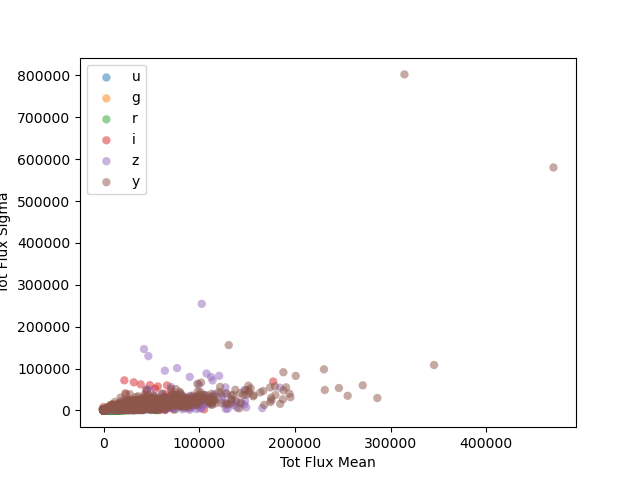

In [18]:
plt.figure()
for band in bands:
    plt.scatter(variable_sample_diao[f'{band}TOTFluxMean'], 
                variable_sample_diao[f'{band}TOTFluxSigma'],
                edgecolor='none',alpha=0.5, label=band)
plt.legend()
plt.xlabel("Tot Flux Mean")
plt.ylabel("Tot Flux Sigma")

## testing John P's cutout service

In [19]:
class PathManager:
    """Manage paths to local files, chunked directories, and s3 buckets.
    Parameters
    ----------
    root : `str`
        Root file path to manage.
    chunk_size : `int`, optional
        How many files per directory?
    """
    def __init__(self, root, chunk_size=None):
        self._root = root
        if chunk_size is not None and chunk_size % 10 != 0:
            raise RuntimeError(f"PathManager file chunking must be a multiple of 10, got {chunk_size}.")
        self._chunk_size = chunk_size

    def __call__(self, id=None, filename=None):
        """Return the full path to this diaSourceId cutout.
        Parameters
        ----------
        id : `int`
            Description
        filename : None, optional
            Description
        Returns
        -------
        TYPE
            Description
        """
        def chunker(id, size):
            return (id // size)*size

        if id is not None:
            if self._chunk_size is not None:
                return os.path.join(self._root, f"images/{chunker(id, self._chunk_size)}/{id}.png")
            else:
                return os.path.join(self._root, f"images/{id}.png")
        elif filename is not None:
            return os.path.join(self._root, filename)

In [20]:
path_manager = PathManager("/sdf/group/rubin/u/parejko/scratch/cutouts", chunk_size=10000)

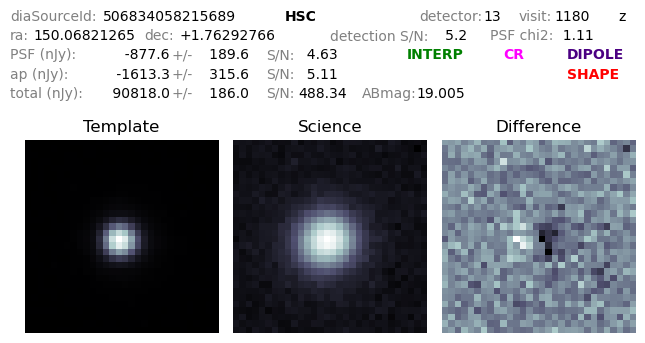

In [21]:
diaSourceId = 506834058215689
path = path_manager(diaSourceId)
display(Image(path))


In [23]:
with apdbQuery.connection as connection:
    sample_ids = pd.read_sql_query('select "diaSourceId" from "DiaSource" LIMIT 10', connection)

In [46]:
#for idx, idi in sample_ids.iterrows():
#    try:
#        path = path_manager(idi.values[0])
#        display(Image(path))
#    except: #FileNotFoundError:
#        continue